## Import the Package

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


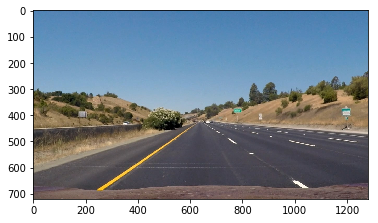

In [2]:
#reading in an image
image = mpimg.imread('test_images/straight_lines1.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


##  Helpful Functions from Porject 1

In [3]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ) 

def plot(img, cmap='gray'):
    plt.imshow(img, cmap=cmap)
    plt.show()

##  Bank of Helpful Functions

In [4]:
def camera_calibration(link='camera_cal/calibration*.jpg'):
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    images = glob.glob(link)
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    return objpoints, imgpoints

def cal_undistort(img, objpoints, imgpoints):
    ret,mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Convert to HLS color space and separate the S channel
# Note: the input "img" is the undistorted image
def advance_combo(img, sx_thresh=(20, 200), s_thresh=(120,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

# Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

# Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

def gaussian_blur(image, kernel=5):
    blurred = cv2.GaussianBlur(image, (kernel,kernel), 0)
    return blurred

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]
    
    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    return histogram

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img, ploty

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fitx, right_fitx, ploty 

def measure_curvature_pixels(ploty):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    # ploty, left_fit, right_fit = generate_data()
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad
def car_offset(leftx, rightx, img_shape, xm_per_pix=3.7/800):
    mid_imgx = img_shape[1]//2      
    car_pos = (leftx[-1] + rightx[-1])/2
    offsetx = (mid_imgx - car_pos) * xm_per_pix
    return offsetx
def annotation(out_img, leftx, rightx, ploty):
    left_curverad,right_curverad = measure_curvature_pixels(ploty)
    # Display curvature_rad 
    cv2.putText(out_img, 'Left curvature: {:.2f} m'.format(left_curverad), 
                (400, 60), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255,255,255), 5)
    cv2.putText(out_img, 'Right curvature: {:.2f} m'.format(right_curverad), 
                (400, 110), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255,255,255), 5)
    # Display car offset
    offset = car_offset(leftx, rightx, out_img.shape)
    cv2.putText(out_img, 'Offset w.r.t center: {:.2f} m'.format(offset), 
                (400, 160), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255,255,255), 5)

## Pipeline combining project 1 + project 2 

In [ ]:
# preparation step 2: identify the Perspective Transform matrix M by the given source and destination points
    src = np.float32(
        [[280,  700],  # Bottom left
         [595,  460],  # Top left
         [725,  460],  # Top right
         [1125, 700]]) # Bottom right

    dst = np.float32(
        [[250,  720],  # Bottom left
         [250,    0],  # Top left
         [1065,   0],  # Top right
         [1065, 720]]) # Bottom right
    M = cv2.getPerspectiveTransform(src, dst)
    left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
    right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])
    

    # PIPELINE
    #step 0 camera calibration
 
    #step 1: use Sobel gradient and HLS color space for much robust lane detection
    #combo=advance_combo(undistorted, sx_thresh=(20, 200), s_thresh=(120,255))
    img_size = (undistorted.shape[1], undistorted.shape[0])
    src = np.float32(
        [[280,  700],  # Bottom left
         [595,  460],  # Top left
         [725,  460],  # Top right
         [1125, 700]]) # Bottom right

    dst = np.float32(
        [[250,  720],  # Bottom left
         [250,    0],  # Top left
         [1065,   0],  # Top right
         [1065, 720]]) # Bottom right
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undistorted, M, img_size)
    # 0 convert to grayscale
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

test5.jpg


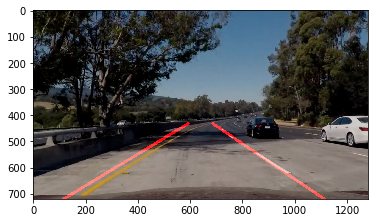

In [12]:
def advance_combo(img, sx_thresh=(10, 255), s_thresh=(120,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])]=1 

# Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] =1
    sobelxxx = cv2.Sobel(s_binary, cv2.CV_64F, 1, 0)
# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, sobelxxx)) * 255

# Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[sobelxxx >0] = 1
# Applies an image mask.
    vertices_right= np.array([[[xsize*0.5,ysize*0.55],[xsize*0.55,ysize*0.55],[xsize*0.9,ysize],[xsize*0.5,ysize]]], dtype=np.int32)
    vertices_left= np.array([[[xsize*0.1,ysize],[xsize*0.45,ysize*0.55],[xsize*0.5,ysize*0.55],[xsize*0.5,ysize]]], dtype=np.int32)
    region_right=region_of_interest(combined_binary,vertices_right)
    region_left=region_of_interest(combined_binary,vertices_left)

# Apply Hough Lines
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 5     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 100 #minimum number of pixels making up a line
    max_line_gap = 100    # maximum gap in pixels between connectable line segments
    line_image = np.copy(test_img)*0 # creating a blank to draw lines on

# Average the position of each of the lines and extrapolate to the top and bottom of the lane.  
    lines_right = cv2.HoughLinesP(region_right, rho, theta, threshold, np.array([]),min_line_length, max_line_gap)
    lines_left = cv2.HoughLinesP(region_left, rho, theta, threshold, np.array([]),min_line_length, max_line_gap)
    line_correct_right=[]
    line_correct_left=[]
    slope_right=[]
    slope_left=[]
    x1_right=[]
    x2_right=[]
    x1_left=[]
    x2_left=[]

    for line in lines_right:
        for x1,y1,x2,y2 in line:
            #slope= (y1-y2)/(x1-x2)
            [slope,b] = np.polyfit([y1, y2],[x1, x2], 1)
            if slope < 2 and slope > 1: 
                #line_correct_right.append(line) 
                slope_right.append(slope)            
                f=np.poly1d([slope,b])
                x1_right.append(f(ysize*0.6))
                x2_right.append(f(ysize))
    for line in lines_left:
        for x1,y1,x2,y2 in line:
            #slope= (y1-y2)/(x1-x2)
            [slope,b] = np.polyfit([y1, y2],[x1, x2],1)
            if slope < -1 and slope > -2: 
                #line_correct_left.append(line)  
                slope_left.append(slope)
                f=np.poly1d([slope,b])
                x1_left.append(f(ysize*0.6))
                x2_left.append(f(ysize))
            
    line_correct=[[[int(np.mean(x1_right)),int(ysize*0.6),int(np.mean(x2_right)),int(ysize)],[int(np.mean(x1_left)),int(ysize*0.6),int(np.mean(x2_left)),int(ysize)]]]
    draw_plot=draw_lines(line_image, line_correct, color=[255, 0, 0], thickness=10)
    lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0) 
    
    return lines_edges

# Pipeline 1 
test_img_list= os.listdir("test_images/")
objpoints, imgpoints = camera_calibration(link='camera_cal/calibration*.jpg');

for img_name in test_img_list[1:2]:
    print(img_name)
    test_img = mpimg.imread("test_images/" + img_name)
# Grab the x and y size and make a copy of the image
    ysize = test_img.shape[0] # 540
    xsize = test_img.shape[1] # 960
# Camera calibration
    undistorted = cal_undistort(test_img, objpoints, imgpoints) 
    img_size = (undistorted.shape[1], undistorted.shape[0])
    combo=advance_combo(undistorted, sx_thresh=(0, 255), s_thresh=(90,255))
    src = np.float32(
        [[280,  700],  # Bottom left
         [595,  460],  # Top left
         [725,  460],  # Top right
         [1125, 700]]) # Bottom right
    dst = np.float32(
        [[250,  720],  # Bottom left
         [250,    0],  # Top left
         [1065,   0],  # Top right
         [1065, 720]]) # Bottom right
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(combo, M, img_size)
    #canny_img=canny(warped, low_threshold=0, high_threshold=255)
    #blurred_img=gaussian_blur(warped,3)
#  use Sobel gradient and HLS color space for much robust lane detection
    plot(combo, cmap='gray')

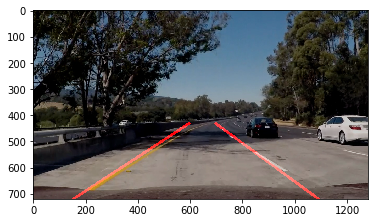

In [15]:
test_img = mpimg.imread("test_images/test5.jpg")
a=advance_combo(test_img, sx_thresh=(10, 255), s_thresh=(120,255))
plt.imshow(a)

In [ ]:
# Applies the Grayscale transform  
    gray_img=grayscale(test_img)
    #print("Convert to grayscale:")
    #plot(gray_img)
    #plt.imsave("test_images_output/" + img_name[:-4] + "_gray.jpg", gray_img, cmap='gray')
    
# Applies the Canny transform
    low_threshold=200
    high_threshold=250
    #print("Apply Canny transform")
    canny_img=canny(gray_img, low_threshold, high_threshold)
    #plot(canny_img, cmap='gray')
    #plt.imsave("test_images_output/" + img_name[:-4] + "_canny.jpg", canny_img, cmap='gray')
    
# Apply a Gaussian Noise kernel
    #print("Apply Gaussian Noise")
    blurred_img=gaussian_blur(canny_img, 51)
    #plot(blurred_img)
    #plt.imsave("test_images_output/" + img_name[:-4] + "_blurred.jpg", blurred_img, cmap='gray')
    
# Apply an image mask = left and right 
    vertices_right= np.array([[[xsize*0.5,ysize*0.6],[xsize*0.55,ysize*0.6],[xsize*0.95,ysize*0.9],[xsize*0.5,ysize*0.9]]], dtype=np.int32)
    vertices_left= np.array([[[xsize*0.1,ysize*0.9],[xsize*0.45,ysize*0.6],[xsize*0.5,ysize*0.6],[xsize*0.5,ysize*0.9]]], dtype=np.int32)
    region_right=region_of_interest(blurred_img,vertices_right)
    region_left=region_of_interest(blurred_img,vertices_left)

# Find the max brightness after left_mask image
    data_left=np.argmax(region_left,axis=1)
    x_left=np.arange(len(data_left));
    data_left_extracted= data_left[data_left > 10]
    x_left_extracted=x_left[data_left > 10]
    fitplot_left=np.poly1d(np.polyfit(x_left_extracted,data_left_extracted, 1))

# Find the max brightness after right_mask image
    data_right=np.argmax(region_right,axis=1)
    x_right=np.arange(len(data_right));
    data_right_extracted= data_right[data_right > 10]
    x_right_extracted=x_right[data_right > 10]
    fitplot_right=np.poly1d(np.polyfit(x_right_extracted,data_right_extracted, 1))

# extroploate the points of interest
    line_image = np.copy(test_img)*0 # creating a blank to draw lines on
    lines=[[[int(fitplot_left(ysize)),int(ysize),int(fitplot_left(ysize*0.6)),int(ysize*0.6)],[int(fitplot_right(ysize)),int(ysize),int(fitplot_right(ysize*0.6)),int(ysize*0.6)]]]
    draw_lines(line_image, lines, color=[255, 0, 0], thickness=10)
    lines_edges = weighted_img(line_image, test_img, 0.9, 1, 0) 
    #plt.imshow(lines_edges, cmap='gray')
    #plt.show()
    plot(lines_edges, cmap='gray')
    #plt.imsave("test_images_output/" + img_name[:-4] + "_final.jpg", lines_edges, cmap='gray')

In [ ]:
image = mpimg.imread('test_images/straight_lines1.jpg')
abc=process_image(image)
plt.imshow(abc)

## First, I'll compute the camera calibration using chessboard images

In [ ]:
# camera_calibration()
objpoints, imgpoints = camera_calibration(link='camera_cal/calibration*.jpg');

## I obatined the objpoints and imgpoints for calibration 

In [ ]:
# cal_undistort()

img = cv2.imread('camera_cal/calibration4.jpg')
undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("output_images/undistort_output.png") # To save figure

## Use Color Transforms, Gradients, etc., to create a Thresholded Binary Image.

In [ ]:
# Convert to HLS color space and separate the S channel
# Note: the input "img" is the undistorted image
# Plotting thresholded images

image = mpimg.imread('test_images/straight_lines1.jpg')
undistorted = cal_undistort(image, objpoints, imgpoints)
combo = advance_combo(undistorted,sx_thresh=(20, 200), s_thresh=(120,255))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted Original')
ax1.imshow(undistorted)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combo, cmap='gray')
plt.savefig("output_images/binary_combo_final.png") 

## Apply a perspective transform to rectify binary image ("birds-eye view")


### Find a trapezoidal shape 

In [ ]:
img.shape[:] 

In [ ]:
plt.imshow(combo[500:720-1,:],cmap='gray')

In [ ]:
data1=combo[680,:]
data2=combo[485,:]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('at line y=680, x1=274 and x2=1046')
ax1.plot(np.arange(len(data1)),data1)

ax2.set_title('at line y=485, x1=546 and x2=743')
ax2.plot(np.arange(len(data2)),data2)

plt.savefig("output_images/line-plot.png") 

(274,680) , (1046,680) ,(546,485) , (743,485)

### Draw the lines and Obtain M 

In [ ]:
image = undistorted            
line_image1 = np.copy(image)*0 # creating a blank to draw lines on
#lines1 = [[[274,680,546,485],[1046,680,743,485]]]
lines1 = [[[269,680,546,485],[1043,680,738,485]]]
draw_lines(line_image1, lines1, color=[255, 0, 0], thickness=10)
lines_edges1 = weighted_img(line_image1, image, 0.9, 1, 0) 
#plt.imshow(lines_edges1, cmap='gray')

src = np.float32(
    [[280,  700],  # Bottom left
     [595,  460],  # Top left
     [725,  460],  # Top right
     [1125, 700]]) # Bottom right

dst = np.float32(
    [[250,  720],  # Bottom left
     [250,    0],  # Top left
     [1065,   0],  # Top right
     [1065, 720]]) # Bottom right 

#src = np.float32([[274,680],[1046,680],[546,485],[743,485]])
#dst = np.float32([[274,680],[1046,680],[274,485],[1046,485]])
#src = np.float32([[269,680],[1043,680],[546,485],[738,485]])
#dst = np.float32([[269,680],[1043,680],[269,485],[1043,485]])
M = cv2.getPerspectiveTransform(src, dst)
img_size = (undistorted.shape[1], undistorted.shape[0])
warped = cv2.warpPerspective(undistorted, M, img_size)

line_image2 = np.copy(undistorted)*0 # creating a blank to draw lines on
#lines2 = [[[274,0,274,719],[1046,0,1046,719]]]
lines2 = [[[267,0,267,719],[1045,0,1043,719]]]
draw_lines(line_image2, lines2, color=[255, 0, 0], thickness=10)
lines_edges2 = weighted_img(line_image2, warped, 0.9, 1, 0) 
#plt.imshow(lines_edges, cmap='gray')

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted Image with source points drawn')
ax1.imshow(lines_edges1)

ax2.set_title('Warped result with dest. lines drawn')
ax2.imshow(lines_edges2)
plt.savefig("output_images/warped_straight_lines.jpg") 

In [ ]:
test_img_list= os.listdir("test_images/")
def plot(img, undistorted, combo, warped, img_name):
    #plt.imshow(img)
    #plt.show()
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    ax1.set_title('Undistorted Image :'+ img_name)
    ax1.imshow(undistorted)
    ax2.set_title('Combo')
    ax2.imshow(combo,cmap='gray')
    ax3.set_title('Warped Image')
    ax3.imshow(warped,cmap='gray')    
    #plt.savefig("output_images/warped_straight_lines.jpg") 
    
for img_name in test_img_list:
    img = mpimg.imread("test_images/" + img_name)
    undistorted = cal_undistort(img, objpoints, imgpoints)
    combo = advance_combo(undistorted,thresh=(20, 200), s_thresh=(120,255))
    warped = cv2.warpPerspective(combo, M, img_size)
    plot(img, undistorted, combo, warped, img_name)

## Detect lane pixels and fit to find the lane boundary.

In [ ]:
#img = mpimg.imread('warped-example.jpg')/255
#img = lines_edges2

# Create histogram of image binary activations
for img_name in test_img_list:
    img = mpimg.imread("test_images/" + img_name)
    undistorted = cal_undistort(img, objpoints, imgpoints)
    combo = advance_combo(undistorted,thresh=(20, 200), s_thresh=(120,255))
    warped = cv2.warpPerspective(combo, M, img_size)
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
# Visualize the resulting histogram
    plt.plot(histogram) 
    plt.title(img_name)
    plt.show()

### find_lane_pixels and fit_polynomial

### [Results] find_lane_pixels and fit_polynomial

In [ ]:
# Load our image
# binary_warped = mpimg.imread('warped-example.jpg')
# binary_warped = lines_edges
for img_name in test_img_list:
    img = mpimg.imread("test_images/" + img_name)
    undistorted = cal_undistort(img, objpoints, imgpoints)
    combo = advance_combo(undistorted,thresh=(20, 200), s_thresh=(120,255))
    warped = cv2.warpPerspective(combo, M, img_size)
    out_img = fit_polynomial(warped)
    plt.imshow(out_img)
    plt.show()

### Finding the Lines- Search from Prior

In [ ]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Load our image - this should be a new frame since last time!
binary_warped = mpimg.imread('Segments/warped-example.jpg')

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(binary_warped)

# View your output
plt.imshow(result)

In [ ]:
# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
#result = search_around_poly(lines_edges2)
# View your output
#plt.imshow(result)

for img_name in test_img_list:
    img = mpimg.imread("test_images/" + img_name)
    undistorted = cal_undistort(img, objpoints, imgpoints)
    combo = advance_combo(undistorted,thresh=(20, 200), s_thresh=(120,255))
    warped = cv2.warpPerspective(combo, M, img_size)
    result = search_around_poly(warped)
    plt.imshow(result)
    plt.show()

## Determine the curvature of the lane and vehicle position with respect to center.

In [ ]:
# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels()

print(left_curverad, right_curverad)
# Should see values of 1625.06 and 1976.30 here, if using
# the default `generate_data` function with given seed number

In [ ]:
for img_name in test_img_list:
    img = mpimg.imread("test_images/" + img_name)
    undistorted = cal_undistort(img, objpoints, imgpoints)
    combo = advance_combo(undistorted,thresh=(20, 200), s_thresh=(120,255))
    warped = cv2.warpPerspective(combo, M, img_size)
    result = search_around_poly(warped)
    left_curverad, right_curverad = measure_curvature_pixels()
    print(left_curverad, right_curverad)

In [ ]:
def car_offset(leftx, rightx, img_shape, xm_per_pix=3.7/800):
    mid_imgx = img_shape[1]//2      
    car_pos = (leftx[-1] + rightx[-1])/2
    offsetx = (mid_imgx - car_pos) * xm_per_pix
    return offsetx

## Warp the detected lane boundaries back onto the original image.


## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [ ]:
objpoints

In [ ]:
imgpoints

In [ ]:
def annotation(out_img, leftx, rightx, ploty):
    left_curverad,right_curverad = measure_curvature_pixels(ploty)
    # Display curvature_rad 
    cv2.putText(out_img, 'Left curvature: {:.2f} m'.format(left_curverad), 
                (400, 60), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255,255,255), 5)
    cv2.putText(out_img, 'Right curvature: {:.2f} m'.format(right_curverad), 
                (400, 110), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255,255,255), 5)
    # Display car offset
    offset = car_offset(leftx, rightx, out_img.shape)
    cv2.putText(out_img, 'Offset w.r.t center: {:.2f} m'.format(offset), 
                (400, 160), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255,255,255), 5)

In [ ]:
def unwarp_distort_back(out_img, )
    unwarped = cv2.warpPerspective(combo, M, img_size)
    dist = cv2.undistort(img, mtx, dist, None, mtx)
    
    
def draw_lane(img, warped_img, left_points, right_points, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_points[0]
    right_fitx = right_points[0]
    ploty = left_points[1]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

## Pipeline Building

In [ ]:
# preparation step 1: find the objpoints, imgpoints from camera calibration
objpoints, imgpoints = camera_calibration(link='camera_cal/calibration*.jpg');
# preparation step 2: identify the Perspective Transform matrix M by the given source and destination points
src = np.float32(
    [[280,  700],  # Bottom left
     [595,  460],  # Top left
     [725,  460],  # Top right
     [1125, 700]]) # Bottom right

dst = np.float32(
    [[250,  720],  # Bottom left
     [250,    0],  # Top left
     [1065,   0],  # Top right
     [1065, 720]]) # Bottom right
M = cv2.getPerspectiveTransform(src, dst)
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])
# build the pipeline
def pipeline(img, sx_thresh, s_thresh, objpoints, imgpoints ,M):
    left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
    right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])
    #step 1: obatin the undistort image 
    undistorted = cal_undistort(img, objpoints, imgpoints)
    #step 2: use Sobel gradient and HLS color space for much robust lane detection
    combo=advance_combo(undistorted, sx_thresh=(20, 200), s_thresh=(120,255))
    img_size = (combo.shape[1], combo.shape[0])
    #step 3: apply Perspective Transform matrix M to "bird-view" 
    binary_warped = cv2.warpPerspective(combo, M, img_size)
    #step 4: apply the polynomial fit on histogram 
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    out_img, ploty = fit_polynomial(binary_warped)
    out_img, left_fitx, right_fitx, ploty = search_around_poly(binary_warped)
    #step 5 Warp the detected lane boundaries back onto the original image
    #out_img = 
    #step 6 annotate metrics onto the origianl image
    annotation(out_img, leftx, rightx, ploty)
    return out_img 

img = mpimg.imread('test_images/straight_lines2.jpg')
# processed image
processed_image = pipeline(img, (20, 100), (170, 255), objpoints, imgpoints, M)
plt.imshow(processed_image)


In [ ]:
test_img_list= os.listdir("test_images/")
for img_name in test_img_list:
    img = mpimg.imread("test_images/" + img_name)
    processed_image = pipeline(img, (20, 100), (170, 255), objpoints, imgpoints, M)
    plt.show()
    plt.imshow(processed_image)


In [ ]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Test on Videos

In [ ]:
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
abc=pipeline(image)
plt.imshow(abc)

In [ ]:
white_output = 'output_video/challenge_video_annotated.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)